In [1]:
library(tidyverse)
library(ggplot2)
library(factoextra)
library(reshape2)
library(umap)
library(ComplexHeatmap)
library(cluster)
library(dynamicTreeCut)
library(uwot)
library(RColorBrewer)
library(circlize)
library(svglite)
library(ggnewscale)

Warning message:
“Paket ‘tidyverse’ wurde unter R Version 4.1.2 erstellt”
── Attaching packages ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.0      ✔ purrr   0.3.5 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.5.0 
✔ readr   2.1.3      ✔ forcats 0.5.2 
Warning message:
“Paket ‘ggplot2’ wurde unter R Version 4.1.2 erstellt”
Warning message:
“Paket ‘tibble’ wurde unter R Version 4.1.2 erstellt”
Warning message:
“Paket ‘tidyr’ wurde unter R Version 4.1.2 erstellt”
Warning message:
“Paket ‘readr’ wurde unter R Version 4.1.2 erstellt”
Warning message:
“Paket ‘purrr’ wurde unter R Version 4.1.2 erstellt”
Warning message:
“Paket ‘dplyr’ wurde unter R Version 4.1.2 erstellt”
Warning message:
“Paket ‘stringr’ wurde unter R Version 4.1.2 erstellt”
Warning message:
“Paket ‘forcats’ wurde unter R Version 4.1.2 erstellt”
── Conflicts ────────────────────────────

In [2]:
#load_dir <- "ARS316/plot_data"
load_dir <- "ARS316"

In [3]:
#methylation <- read_csv(paste(load_dir, "/ARS316_feature_methylation_annotation_v3.csv", sep=""), show_col_types = FALSE)
#methylation <- methylation[, -1]
#methylation$feature <- factor(methylation$feature, 
#                              levels = c('ns-3', 'L-2', 'ns-2', 'L-1', 'ns-1', 'ARS316', 
#                                         'ns+1', 'ns+2', 'L+2', 'ns+3'))
#methylation$condition <- factor(methylation$condition)
#methylation$strand <- factor(methylation$strand)

In [4]:
#colnames(methylation)[4] <- "norm_methylation"

In [5]:
#Load a feature annotation with different annotation with fixed window sizes
#methylation <- read.csv(paste(load_dir, "/ARS316_feature_methylation_window50_selected.csv", sep=""), 
#                            stringsAsFactors=TRUE)
methylation <- read.csv(paste(load_dir, "/ARS316_feature_methylation_window30_union_selected.csv", sep=""), 
                            stringsAsFactors=TRUE)
methylation <- methylation[, -1]

levels(methylation$condition) <- c("dies6", "disw2", "wt")
methylation$feature <- factor(methylation$feature, levels = c(seq(1:max(methylation$feature))))

In [6]:
levels(methylation$condition)

[1] "dies6" "disw2" "wt"

In [7]:
# test clustering only on positive or negative strand:
methylation %>% group_by(strand) %>% count() #for each strand, we have 97356 feature methylation values

methylation = methylation[methylation$strand == "plus", ]

strand,n
<fct>,<int>
minus,97356
plus,97356


In [8]:
methylation_long <- dcast(methylation, molecule + condition + replicate + strand ~feature, value.var = "norm_methylation")


In [9]:
scaled_meth <- scale(methylation_long[,-(1:4)])

In [10]:
#define linkage methods
#m <- c( "average", "single", "complete", "ward")
#names(m) <- c( "average", "single", "complete", "ward")

#function to compute agglomerative coefficient
#ac <- function(x) {
#  agnes(scaled_meth, method = x)$ac
#}
#
#calculate agglomerative coefficient for each clustering linkage method
#sapply(m, ac)"""

In [11]:
pca_meth <- prcomp(scaled_meth)

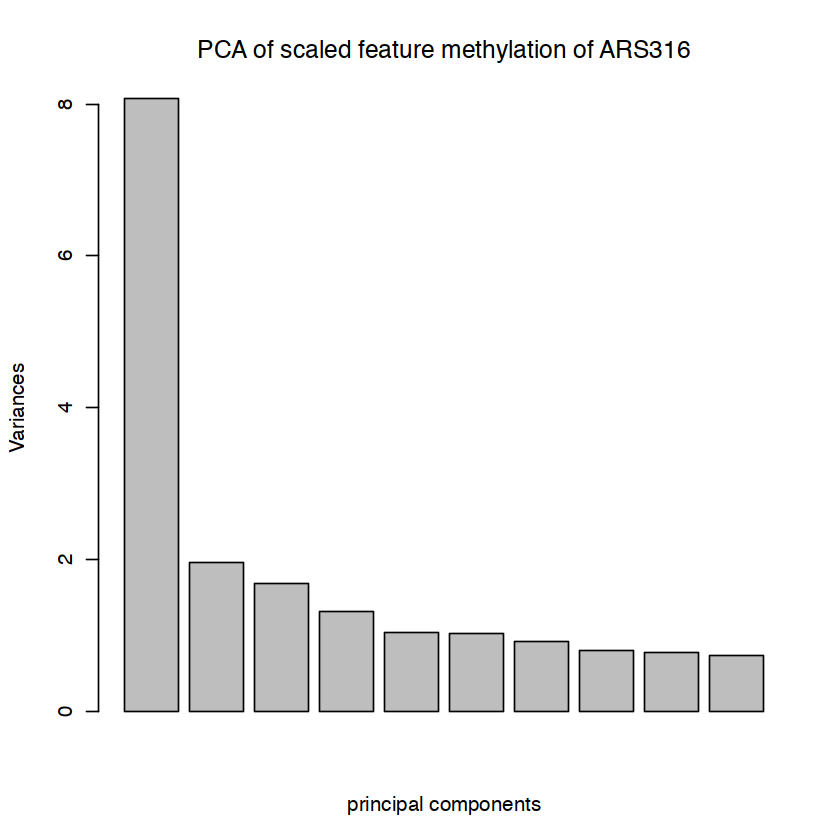

In [12]:
plot(pca_meth, main = "PCA of scaled feature methylation of ARS316", xlab = "principal components")

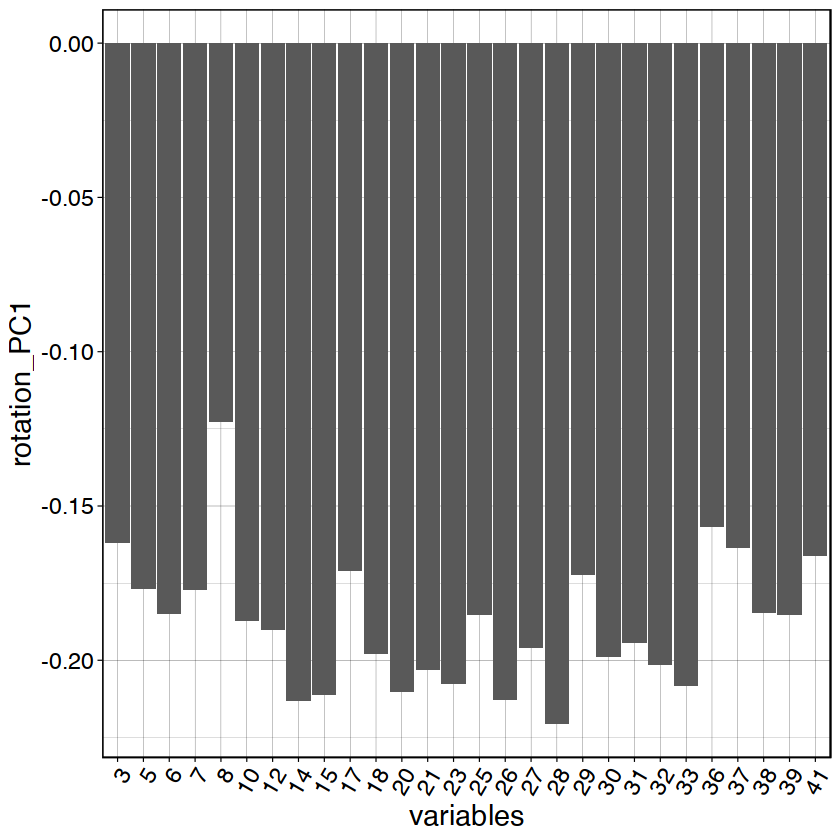

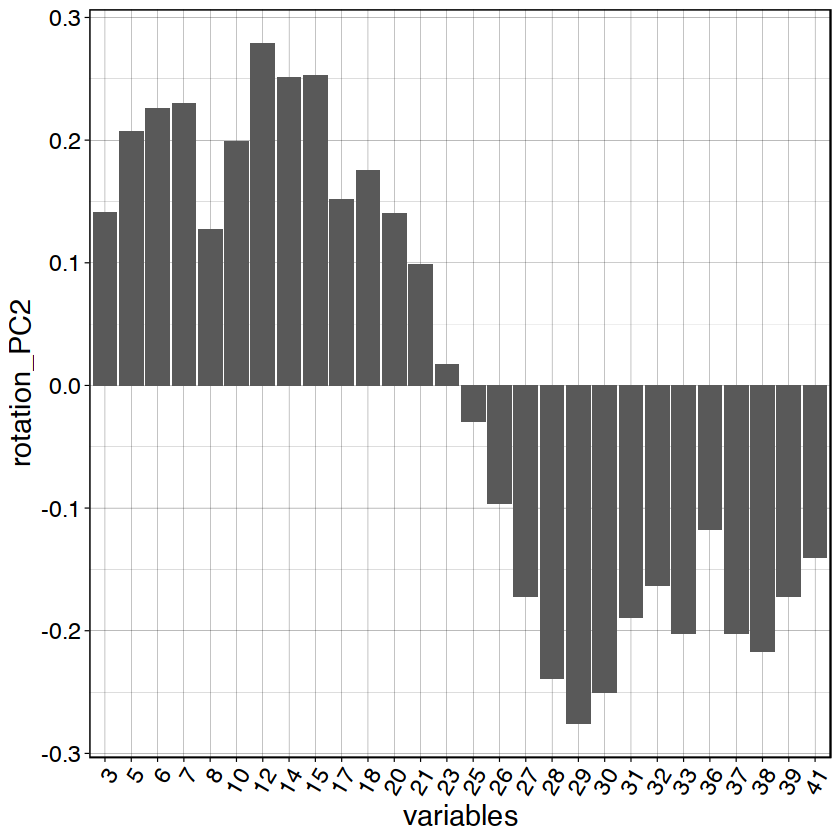

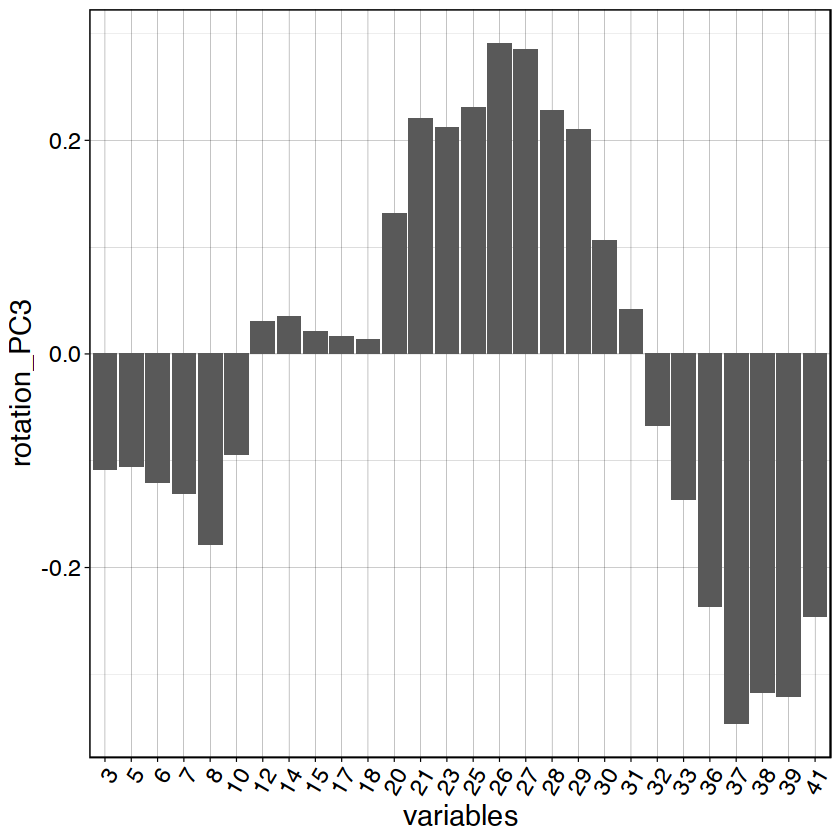

In [13]:
pca.summary <- summary(pca_meth)

df_plot <- data.frame("variables"= rownames(pca.summary$rotation),
                 "rotation_PC1" = pca.summary$rotation[,1],
                 "rotation_PC2" = pca.summary$rotation[,2],
                 "rotation_PC3" = pca.summary$rotation[,3])

#df_plot$variables <- factor(df_plot$variables, levels = c('ns-3', 'L-2', 'ns-2', 'L-1', 'ns-1', 'ARS316', 
#                                         'ns+1', 'ns+2', 'L+2', 'ns+3'))

df_plot$variables <- factor(rownames(pca.summary$rotation), 
                            levels = rownames(pca.summary$rotation))

ggplot(df_plot) + theme_linedraw() +
  geom_col(aes(x= variables, y = rotation_PC1)) + 
  theme(text = element_text(size=17),
        axis.text.x = element_text(angle = 60, hjust=1))

ggplot(df_plot) + theme_linedraw() +
  geom_col(aes(x= variables, y = rotation_PC2)) + 
  theme(text = element_text(size=17),
        axis.text.x = element_text(angle = 60, hjust=1))

ggplot(df_plot) + theme_linedraw() +
  geom_col(aes(x= variables, y = rotation_PC3)) + 
  theme(text = element_text(size=17),
        axis.text.x = element_text(angle = 60, hjust=1))

In [70]:
#clust <- agnes(scaled_meth, method = "ward")

In [71]:
#clust$ac

[1] 0.9928471

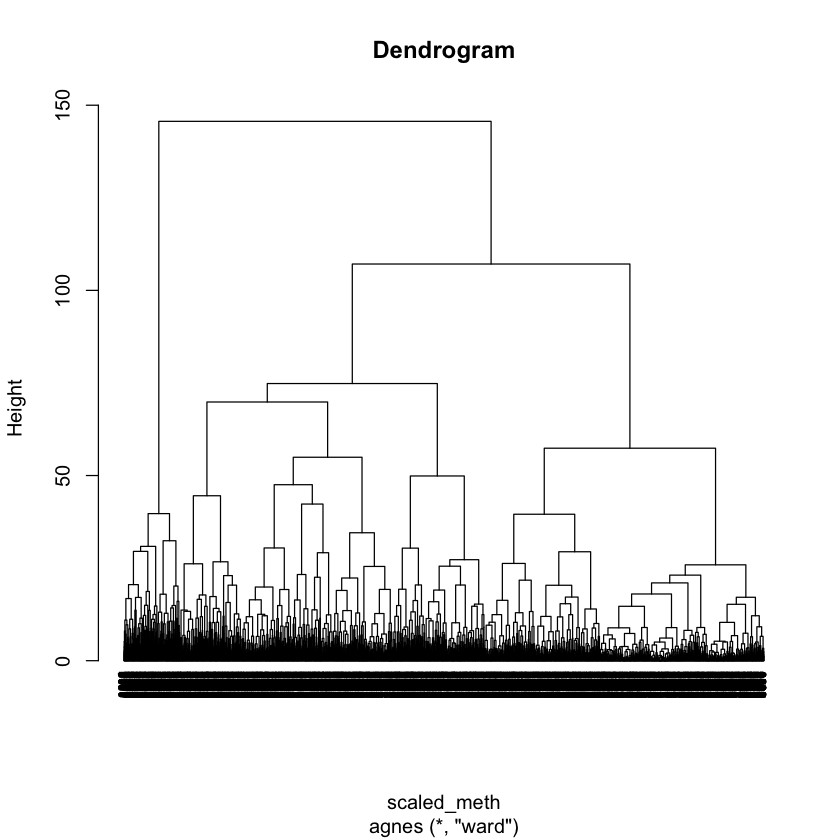

In [73]:
#produce dendrogram
#pltree(clust, cex = 0.6, hang = -1, main = "Dendrogram")

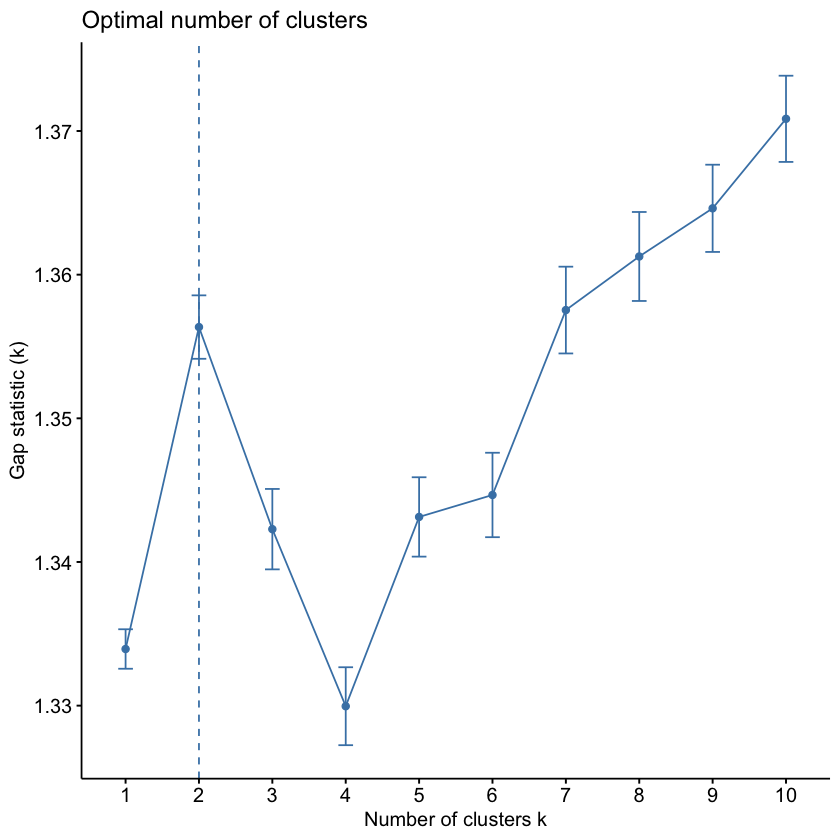

In [59]:
#This step is computationally very expensive. Avoid rerunning if possible (or run overnight)

#calculate gap statistic for each number of clusters (up to 10 clusters)
#gap_stat <- clusGap(scaled_meth, FUN = hcut, nstart = 25, K.max = 10, B = 50)

#produce plot of clusters vs. gap statistic
#fviz_gap_stat(gap_stat)

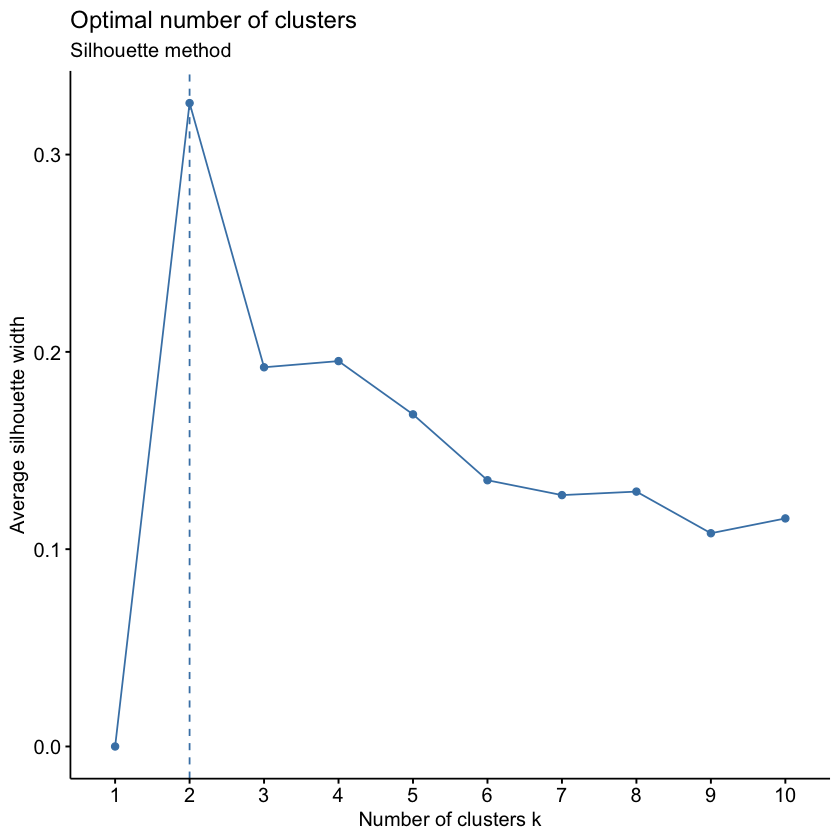

In [60]:
fviz_nbclust(scaled_meth, kmeans, method = "silhouette") +
  labs(subtitle = "Silhouette method")

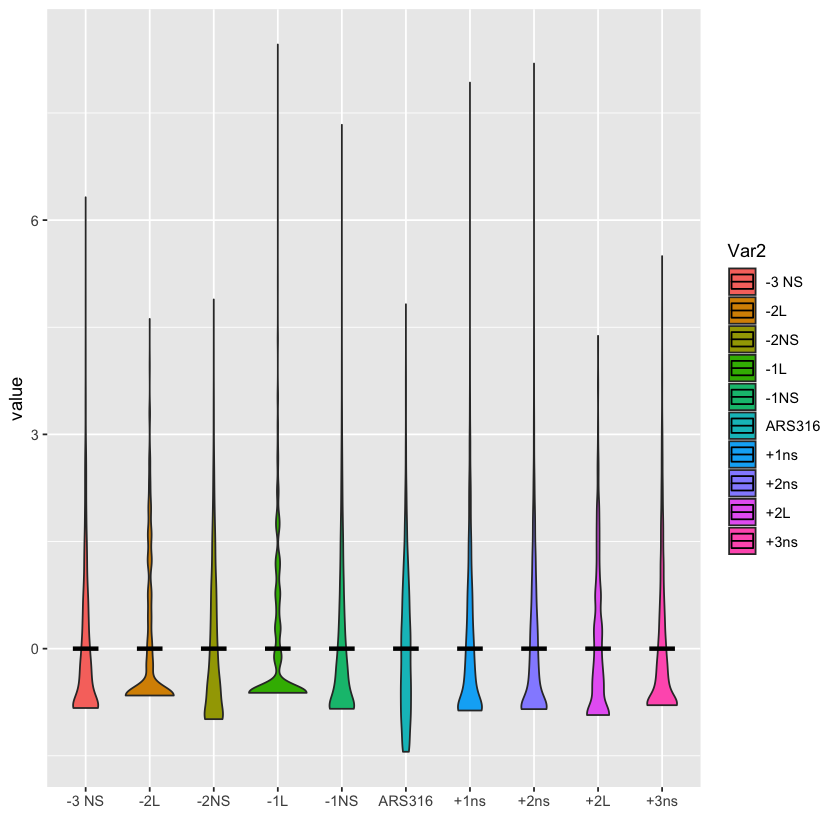

In [15]:
scaled_meth.melt <- melt(scaled_meth)

ggplot(scaled_meth.melt, aes(x = Var2, y = value, fill = Var2)) + 
geom_violin() + 
xlab("") + 
stat_summary(fun = "mean", geom = "crossbar", color = "black", width = 0.4)

In [129]:
#compute distance matrix
#d <- dist(scaled_meth, method = "euclidean")

#perform hierarchical clustering using Ward's method
#final_clust <- hclust(d, method = "ward.D2" )

#cut the dendrogram into 4 clusters
#groups <- cutree(final_clust, k=4)

In [130]:
#groups <- cutreeDynamic(corr_clust, distM= as.matrix(d),
#                             method="hybrid", deepSplit = 0.0, minClusterSize = 100)

#find number of observations in each cluster
#table(groups)

In [87]:
#aggr_data <- cbind(methylation_long, groups)

In [88]:
#umap_scaled <- umap(scaled_meth, metric= "euclidean")

In [131]:
#plot_data <- cbind(umap_scaled, aggr_data)
#plot_data$groups <- factor(plot_data$groups)

#colnames(plot_data)[1:2] = c("UMAP1", "UMAP2")

#ggplot(plot_data, aes(x = UMAP1, y = UMAP2, color= groups)) + 
#  theme_linedraw() + 
#  geom_point(alpha = 0.5) +
#  labs(title = "Clustering ARS313 features") +
#  scale_x_continuous(limits = c(-10,10)) +
#  scale_y_continuous(limits = c(-10, 10))

#ggplot(plot_data, aes(x = UMAP1, y = UMAP2, color= condition)) + 
#  theme_linedraw() + 
#  geom_point(alpha=0.6) +
#  scale_color_brewer(type = "qual", palette = "Set2") +
#  labs(title = "Clustering ARS313 features") +
#  scale_x_continuous(limits = c(-10,10)) +
#  scale_y_continuous(limits = c(-10, 10))

In [132]:
#ggplot(plot_data, aes(x = UMAP1, y = UMAP2, color= strand)) + 
#  theme_linedraw() + 
#  geom_point(alpha = 0.5) +
#  labs(title = "Clustering ARS313 features") +
#  scale_x_continuous(limits = c(-10,10)) +
#  scale_y_continuous(limits = c(-10, 10))

In [21]:
#set.seed(43)
#k <- kmeans(scaled_meth, centers= 2,
#            nstart = 10)  
## number of data points in each cluster
#table(k$cluster)

#quality of partition as Between sum of squares / total sum of squares
#100 * k$betweenss/k$totss

#sil <- silhouette(k$cluster, dist(scaled_meth))
#fviz_silhouette(sil) +
#  scale_fill_brewer(type = "qual", palette = "Set2")

In [133]:
#ggplot(data = aggr_data, aes(x = groups, fill = condition)) +
#  geom_bar(position = "fill") + ylab("proportion") + 
#  ggtitle("Proportions of conditions per cluster")

#ggplot(data = aggr_data, aes(x = groups, fill = strand)) +
#  geom_bar(position = "fill") + ylab("proportion") + 
#  ggtitle("Proportions of conditions per cluster")

#ggplot(data = aggr_data, aes(x = groups, fill = replicate)) +
#  geom_bar(position = "fill") + ylab("proportion") + 
#  ggtitle("Proportions of conditions per cluster")

In [92]:
#aggr_data$groups <- as.factor(aggr_data$groups)

In [134]:
#plot_pc_aggr_data <- cbind(pca_meth$x[,1:2], aggr_data)

#ggplot(plot_pc_aggr_data) + 
#theme_linedraw() + 
#geom_point(aes(x = PC1, y = PC2, color = groups)) 

#ggplot(plot_pc_aggr_data, aes(x = PC1, y = PC2, color= condition)) + 
#  theme_linedraw() + 
#  geom_point() +
#  scale_color_brewer(type = "qual", palette = "Set2") +
#  labs(title = "PCA")

In [135]:
#aggr_data

#col1 <- brewer.pal(6, "Set2")

#heatmap(as.matrix(aggr_data[,5:13]), Colv=NA, Rowv= as.dendrogram(final_clust), scale = "none",
#       main = "Scaled feature expression", RowSideColors = col1[groups]
#       )

## Cluster data based on correlation of methylation than on scaled features

In [14]:
cor_mat <- cor(t(scaled_meth),method="spearman")
dissim_mat <- sqrt((1-cor_mat)/2)
dist_mat <- as.dist(dissim_mat)
corr_clust <- hclust(dist_mat, method="ward.D2")

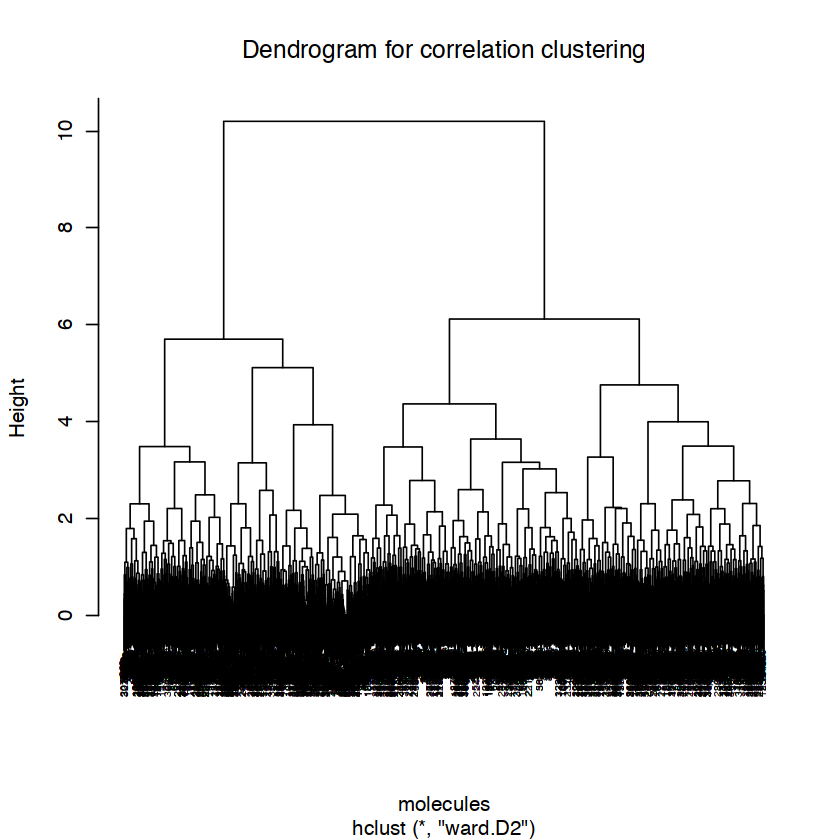

In [15]:
plot(x = corr_clust, cex = 0.5,  labels =  row.names(corr_clust), main = "Dendrogram for correlation clustering",
    xlab = "molecules")

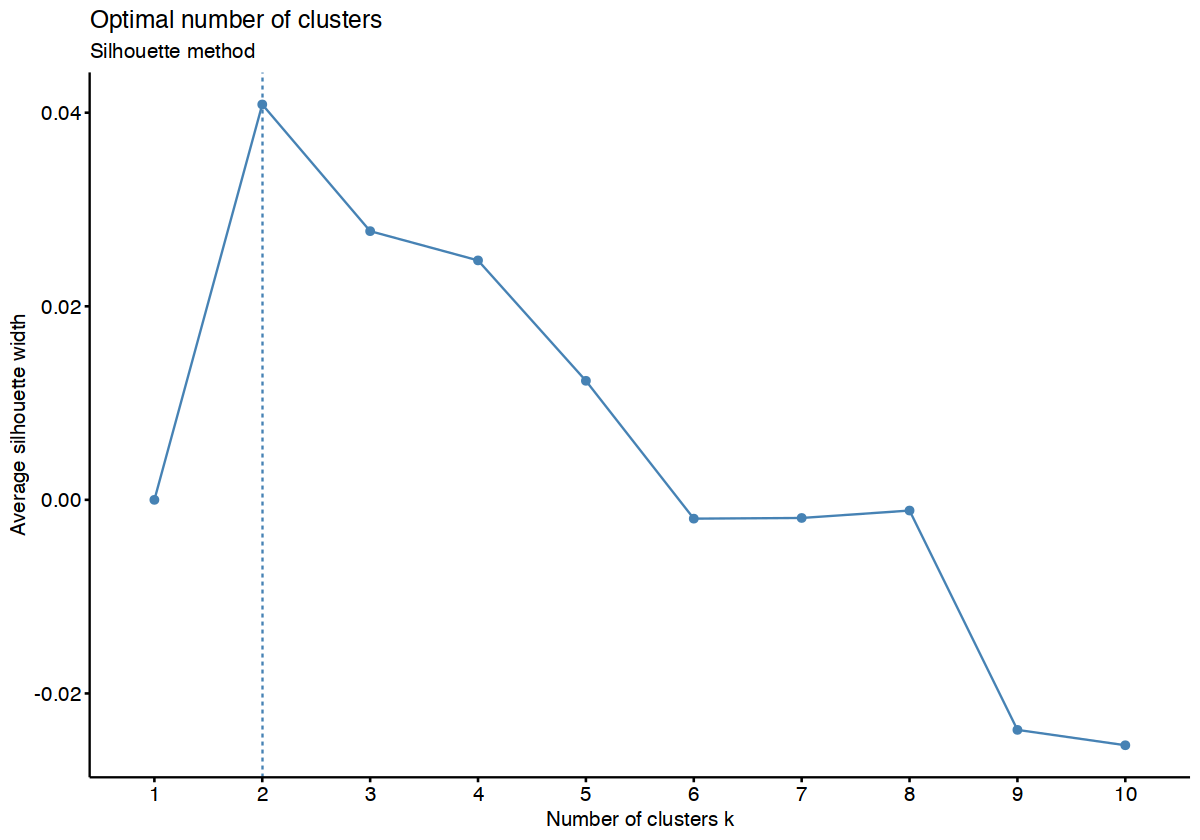

In [53]:
fviz_nbclust(scaled_meth, 
             hcut,
             diss = dist_mat,
             method = "silhouette") +
  labs(subtitle = "Silhouette method")

In [16]:
#cut the dendrogram into 4 clusters
corr_groups <- cutree(corr_clust, k=5)
#corr_groups <- cutreeDynamic(corr_clust, distM= as.matrix(d),
#                             method="hybrid", deepSplit = 0, minClusterSize = 100)

#find number of observations in each cluster
table(corr_groups)

corr_groups
   1    2    3    4    5 
1133  550  299 1004  491 

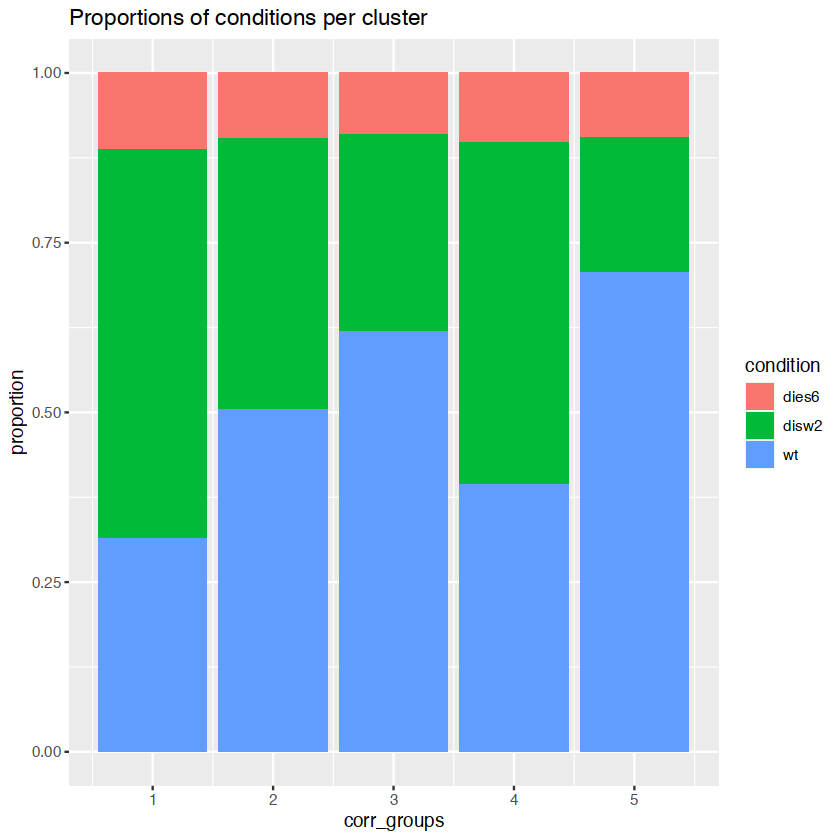

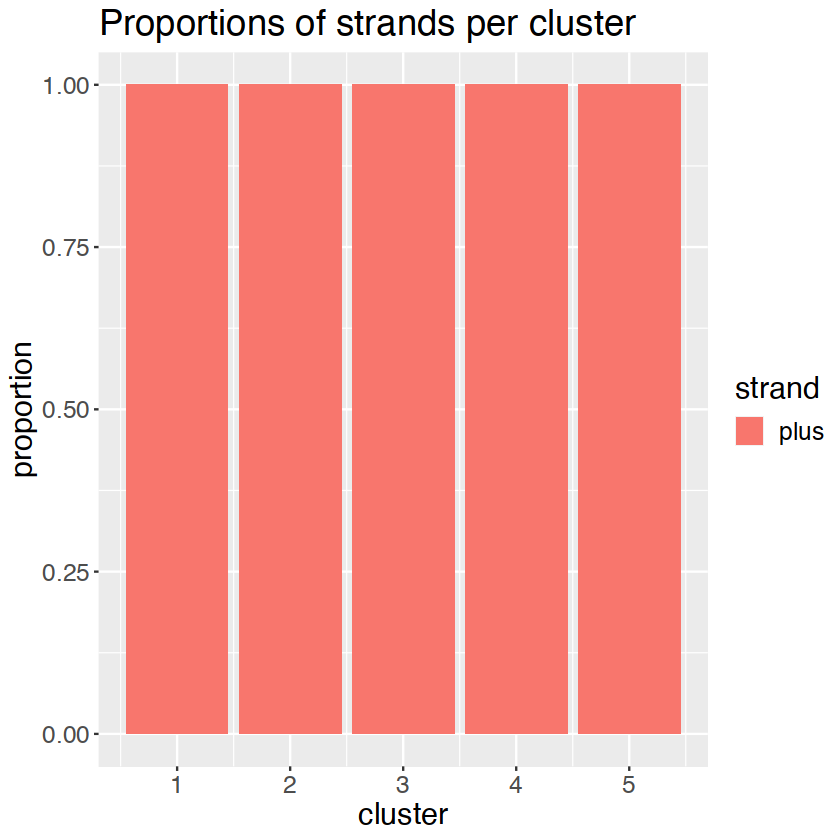

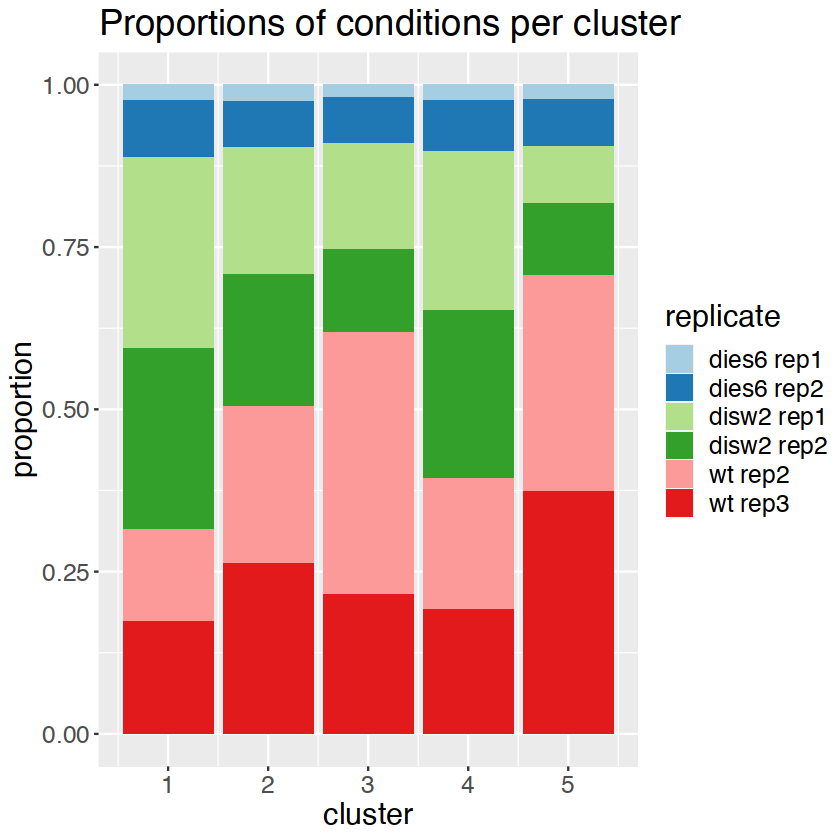

In [17]:
aggr_corr_data <- cbind(methylation_long, corr_groups)

ggplot(data = aggr_corr_data, aes(x = corr_groups, fill = condition)) +
  geom_bar(position = "fill") + ylab("proportion") + 
  ggtitle("Proportions of conditions per cluster")

ggplot(data = aggr_corr_data, aes(x = corr_groups, fill = strand)) +
  geom_bar(position = "fill") + ylab("proportion") + 
  ggtitle("Proportions of strands per cluster")  +
  xlab("cluster") + 
  theme(text = element_text(size = 18))
#ggsave(paste(load_dir, "/plots/cluster_strands_ARS316.svg", sep =""), width = 7, height = 5)

ggplot(data = aggr_corr_data, aes(x = corr_groups, fill = replicate)) +
  geom_bar(position = "fill") + ylab("proportion") + 
  ggtitle("Proportions of conditions per cluster") + 
  scale_fill_brewer(type = "qual", palette = "Paired") +
  xlab("cluster") + 
  theme(text = element_text(size = 18))
#ggsave(paste(load_dir, "/plots/cluster_conditions_ARS316.svg", sep =""), width = 7, height = 5)

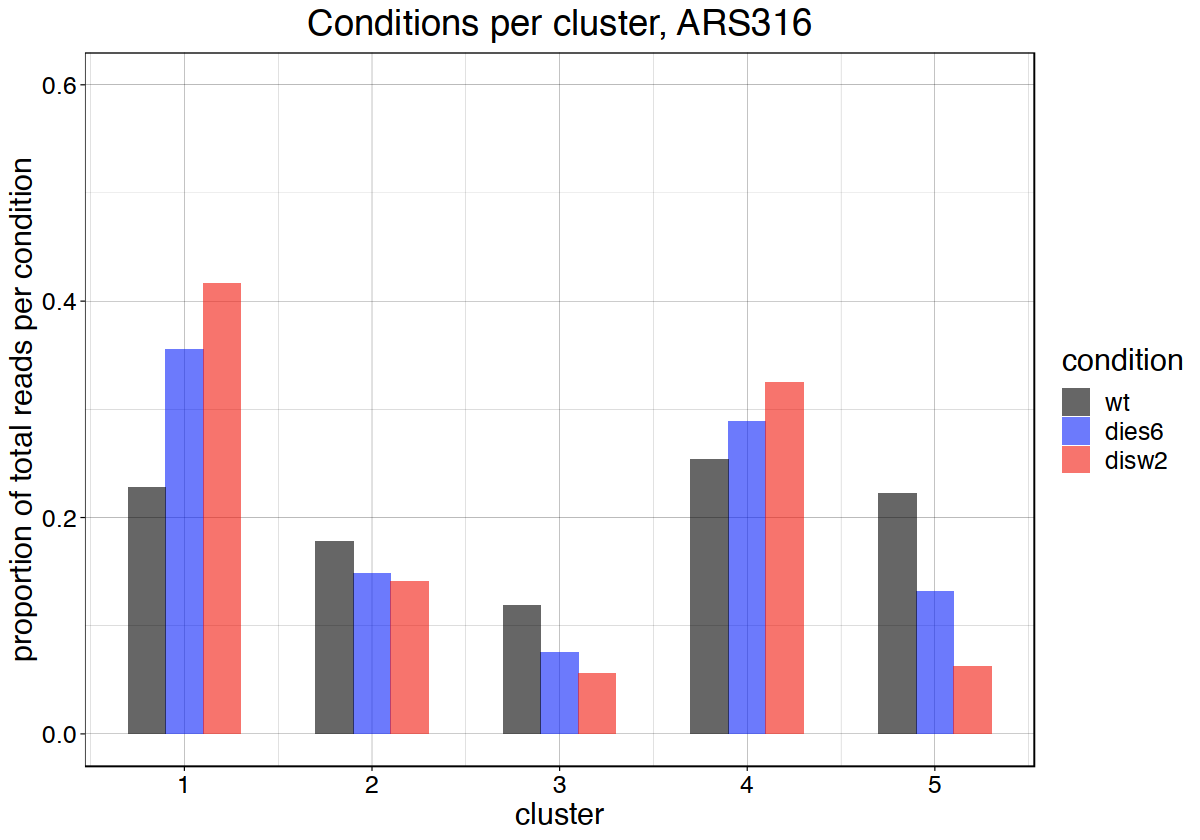

In [18]:
#total <- aggr_corr_data %>% group_by(condition) %>% summarise(n())
#colnames(total)[2] <- "n"
#total$corr_groups <- "total"
#total$`n()`<- colSums(total[,2])

summarise_proportions <- merge(aggr_corr_data %>% group_by(corr_groups) %>% count(condition),
                               aggr_corr_data %>% group_by(condition) %>% summarise(n()))

#summarise_proportions$corr_groups <- factor(summarise_proportions$corr_groups, 
#                                            levels = c(unique(summarise_proportions$corr_groups), "total"))

#summarise_proportions <- rbind(summarise_proportions, total)
summarise_proportions$proportion <- summarise_proportions$n/summarise_proportions$`n()`
summarise_proportions$condition <- factor(summarise_proportions$condition, levels = c("wt", "dies6", "disw2"))

options(repr.plot.width=10, repr.plot.height=7)

ggplot(data = summarise_proportions, aes(x = corr_groups, y=proportion, fill = condition)) +
  theme_linedraw() + 
  geom_col(position = "dodge", alpha = 0.6, width = 0.6
          #position = position_dodge(width = 1), width=0.7
          ) +
  scale_fill_manual(values = c("wt" = "black",
                               "dies6" = "#0a22fa", 
                               "disw2" = "#f2180c")) + 
  ylim(0, 0.6) + 
  xlab("cluster") + 
  ylab("proportion of total reads per condition") + 
  ggtitle("Conditions per cluster, ARS316") + 
  theme(text = element_text(size=18),
       plot.title = element_text(hjust = 0.5))
#ggsave(paste(load_dir, "/plots/cluster_occupation_ARS316.svg", sep =""), width = 10, height = 7)

In [19]:
#chi square distance 

chi_dist <- function(vector_a, vector_b){
    if(length(vector_a) == length(vector_b)){
        chi <- 0.5 * sum((vector_a - vector_b)**2/(vector_a + vector_b))
        return(chi)
    }
    else
        print("Error: vectors need to have the same length. Check input values.")
    
}

for(value in unique(summarise_proportions$condition)){
    a = chi_dist(summarise_proportions %>% filter(condition == "wt") %>%arrange(corr_groups) %>% pull(proportion),
                 summarise_proportions %>% filter(condition == value) %>%arrange(corr_groups) %>% pull(proportion)
                 )
    print(paste(value, a))
    }

[1] "dies6 0.0327661630702535"
[1] "disw2 0.0904509921614615"
[1] "wt 0"


In [20]:
#umap_corr <- umap(scaled_meth, metric = "correlation")

In [21]:
#colnames(umap_corr) <- c("UMAP1", "UMAP2")

In [22]:
#corr_plot_data <- cbind(umap_corr, aggr_corr_data)
#corr_plot_data$corr_groups <- factor(corr_plot_data$corr_groups)#

#colnames(corr_plot_data)[1:2] = c("UMAP1", "UMAP2")

#ggplot(corr_plot_data, aes(x = UMAP1, y = UMAP2, color= corr_groups)) + 
#  theme_linedraw() + 
#  geom_point(alpha = 0.5) +
#  labs(title = "Clustering ARS313 features") +
#  scale_x_continuous(limits = c(-10,10)) +
#  scale_y_continuous(limits = c(-10, 10))

#ggplot(corr_plot_data, aes(x = UMAP1, y = UMAP2, color= condition)) + 
#  theme_linedraw() + 
#  geom_point(alpha=0.6) +
#  scale_color_brewer(type = "qual", palette = "Set2") +
#  labs(title = "Clustering ARS313 features") +
#  scale_x_continuous(limits = c(-10,10)) +
#  scale_y_continuous(limits = c(-10, 10))

#ggplot(corr_plot_data, aes(x = UMAP1, y = UMAP2, color= strand)) + 
#  theme_linedraw() + 
#  geom_point(alpha=0.6) +
#  scale_color_brewer(type = "qual", palette = "Set2") +
#  labs(title = "Clustering ARS313 features") +
#  scale_x_continuous(limits = c(-10,10)) +
#  scale_y_continuous(limits = c(-10, 10))

In [23]:
#for( i in 1:ncol(scaled_meth)){
#    print(range(scaled_meth[,i]))
#    }

In [24]:
#col <- brewer.pal(10, "RdYlBu")
#col1 <- brewer.pal(6, "Set2")
#col2 <- brewer.pal(4, "Greys")
#col3 <- c("#ffffff", "#9fc5e8", "#16537e")

#heatmap(scaled_meth, Colv=NA, Rowv= as.dendrogram(corr_clust),
#        scale = "none",
#        main = "Scaled feature expression",
#        col = col2,
#        RowSideColors = col1[corr_groups]
#       )

In [25]:
#brewer.pal(5, "Dark2")
#brewer.pal(5, "Set2")
#brewer.pal(9, "Set1")

#col_Anna = ["black", "#0a22fa", "#f2180c"]

In [26]:
#introduce total methylation level as column to try this is the heatmap

#scaled_meth <- cbind(scaled_meth, rowSums(scaled_meth))
#colnames(scaled_meth)[ncol(scaled_meth)] = "total_meth"

In [27]:
aggr_corr_data$total_meth <- rowSums(aggr_corr_data[,5:14])
aggr_corr_data %>% group_by(corr_groups) %>% summarise(mean(total_meth))

corr_groups,mean(total_meth)
<int>,<dbl>
1,12.427157
2,8.892190
3,5.863043
4,15.850204
5,5.320962


`use_raster` is automatically set to TRUE for a matrix with more than
2000 rows. You can control `use_raster` argument by explicitly setting
TRUE/FALSE to it.

Set `ht_opt$message = FALSE` to turn off this message.

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



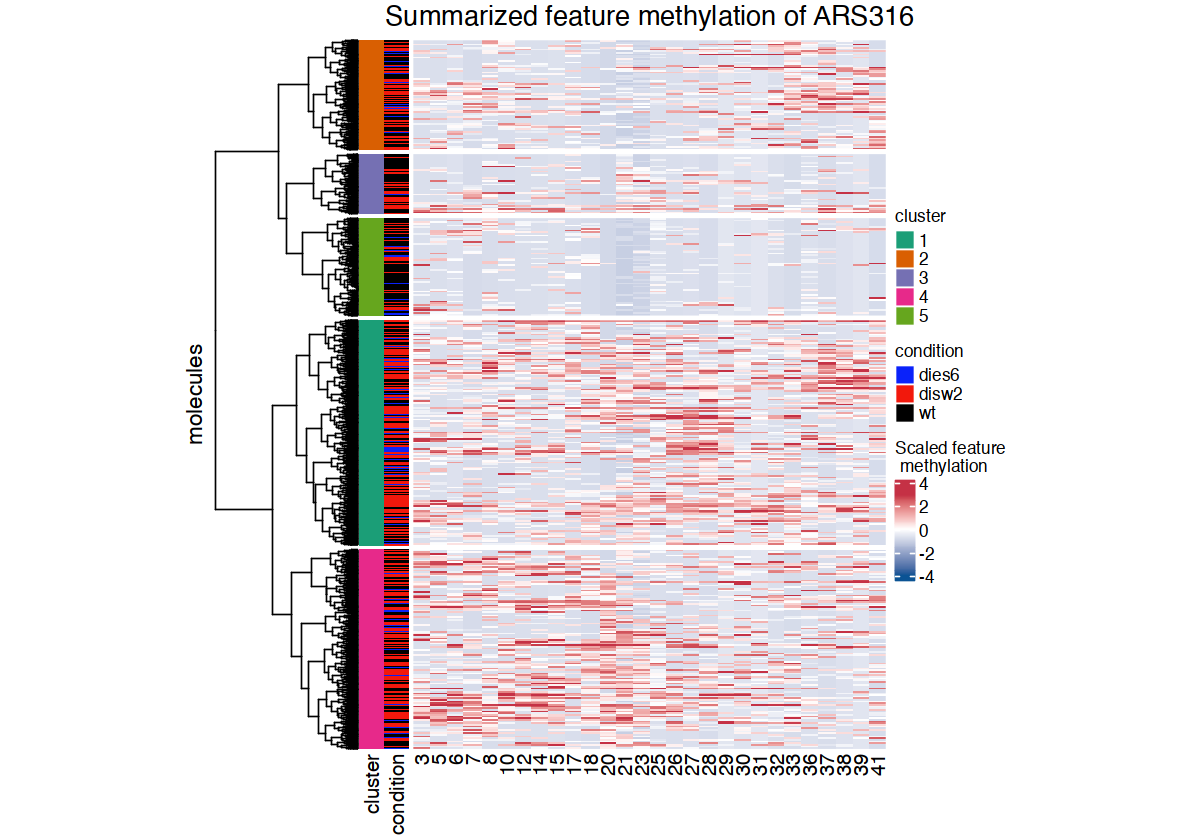

In [28]:
num_cluster <- length(unique(corr_groups))

col_list <- list(cluster = c("1" = '#1B9E77', "2" = '#D95F02', "3" = '#7570B3', "4" = '#E7298A', "5" = '#66A61E', "6" = '#e6ab02'),
                 condition = c("wt" = "black", "dies6" = "#0a22fa", "disw2" = "#f2180c"))
#Heatmap annotation
ha <- rowAnnotation(
    cluster = corr_groups, 
    condition = aggr_corr_data$condition, #insert replicate ?
    col = col_list 
)


color_func <- colorRamp2(c(-4,0,3), c("#0b5394", "white", "#c53145"))

Heatmap(scaled_meth, name = "Scaled feature \n methylation", #title of legend
       row_title = "molecules",
       show_row_names = FALSE,
        row_split = num_cluster,
        cluster_columns = FALSE,
        cluster_rows = as.dendrogram(corr_clust), row_dend_width = unit(3, "cm"),
        width = unit(10, "cm"), height = unit(15, "cm"),
        col = color_func, 
        column_title = "Summarized feature methylation of ARS316", column_title_gp = gpar(fontsize = 16, fontface = "bold"),
        left_annotation = ha
       )

### In order to have the clusters on the left of the heatmap in a consistent order with their numbering, assign a new variable clusters_new with a custom order of the clusters in the heatmap. (Alternative: reorder the hcust object or the dendrogram)

In [29]:
cluster_new <- factor(corr_groups)

In [30]:
levels(cluster_new) #cluster are in the ascending order. Now assign each cluster the position it should have in the new plot.

[1] "1" "2" "3" "4" "5"

In [31]:
levels(cluster_new) <- c(4,1,2,5,3) #c(3,1,2,4,5)

`use_raster` is automatically set to TRUE for a matrix with more than
2000 rows. You can control `use_raster` argument by explicitly setting
TRUE/FALSE to it.

Set `ht_opt$message = FALSE` to turn off this message.

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



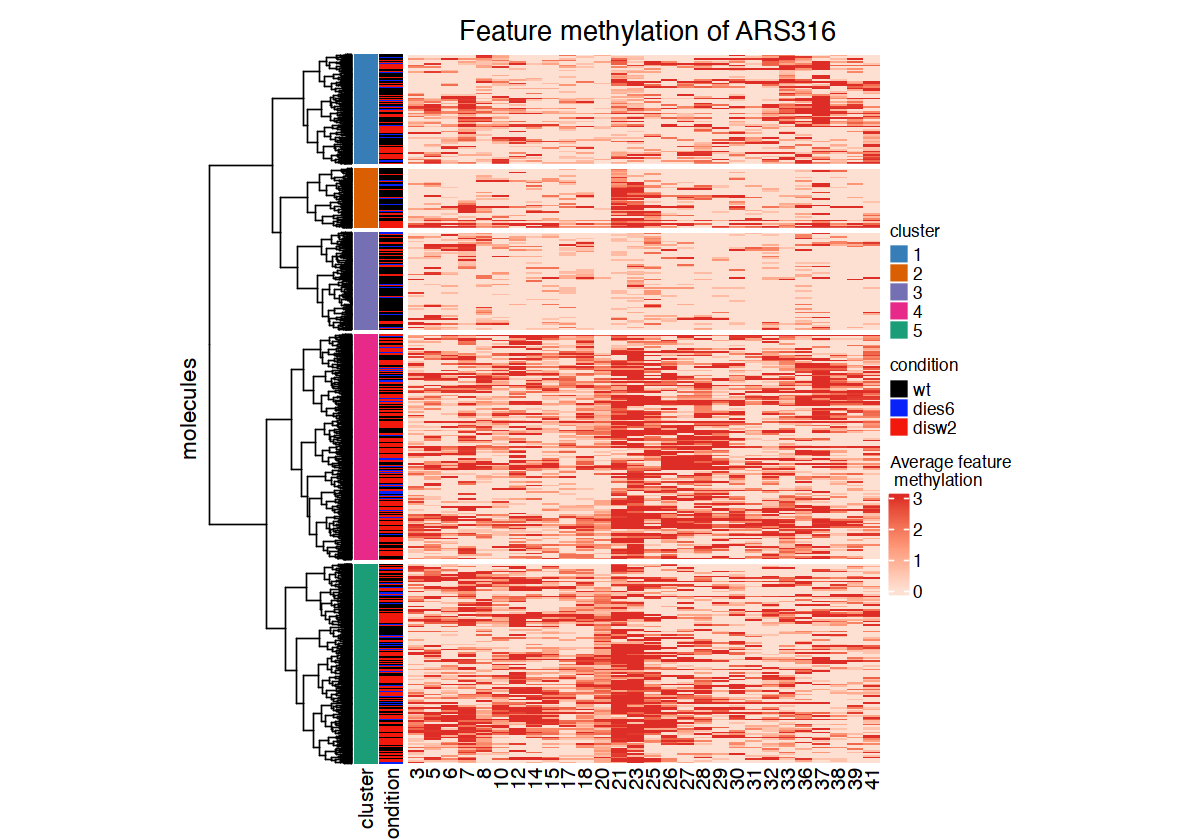

In [32]:
##Heatmap annotation

col_list <- list(cluster = c("1" = '#377eb8', "2" = '#D95F02', "3" = '#7570B3', "4" = '#E7298A', "5" = '#1B9E77', "6" = '#e6ab02', "7" = '#a6761d'),
                 condition = c("wt" = "black", "dies6" = "#0a22fa", "disw2" = "#f2180c"))

ha <- rowAnnotation(
    cluster = factor(cluster_new, levels = c(1,2,3,4,5)), 
    condition = factor(aggr_corr_data$condition, levels = c("wt", "dies6", "disw2")),
    col = col_list 
)

color_func <- colorRamp2(c(0,1.5,3), brewer.pal(3, "Reds"))

#pdf(paste(load_dir, "/plots/heatmap_5cluster_ARS316_revision.pdf", sep=""), width= 10, height=15)
Heatmap(as.matrix(aggr_corr_data[,5:(ncol(aggr_corr_data)-2)]), name = "Average feature \n methylation", #title of legend
       row_title = "molecules",
       show_row_names = FALSE,
        cluster_columns = FALSE,
        row_split = num_cluster, cluster_rows = as.dendrogram(corr_clust), row_dend_width = unit(3, "cm"),
        
        width = unit(10, "cm"), height = unit(15, "cm"),
        col = color_func, 
        column_title = " \n Feature methylation of ARS316", 
        column_title_gp = gpar(fontsize = 16, fontface = "bold"),
        left_annotation = ha
       )
#dev.off()

## Plot this heatmap more simplified by displaying the average methylation by feature and cluster

In [33]:
aggr_corr_data$corr_groups <- cluster_new

In [34]:
simple_heatmap_data <- aggr_corr_data[,5:(ncol(aggr_corr_data)-1)] %>% melt(id.vars="corr_groups", 
                                                                            variable.name= "feature") %>%
                       group_by(corr_groups, feature) %>% summarise(avg = round(mean(value), digits =2))

`summarise()` has grouped output by 'corr_groups'. You can override using the `.groups` argument.


In [35]:
simple_heatmap_data$corr_groups <- factor(simple_heatmap_data$corr_groups, levels = c(1,2,3,4,5))

In [36]:
quantile(simple_heatmap_data$avg, probs = c(0, 0.1, 0.5, 0.75, 0.90, 1))

0%    10%    50%    75%    90%   100% 
0.0500 0.2980 0.9650 1.3725 2.1660 4.9300

In [37]:
simple_heatmap_plotdata <- dcast(simple_heatmap_data, corr_groups ~feature, value.var = "avg")

In [38]:
add_columns_df = as.data.frame(matrix(1:34, ncol = 34))
colnames(add_columns_df) = seq(34)

# add the columns with non-significant methylation difference between wt and mutants, fill with NAs
full_features_df = merge(simple_heatmap_plotdata, add_columns_df, all =TRUE)

full_features_df <- full_features_df[is.na(full_features_df[,ncol(full_features_df)]),] # remove the row of the dummy dataframe

full_features_df <- full_features_df[order(as.numeric(full_features_df$corr_groups)), ] #reorder rows according to cluster info
full_features_df <- subset(full_features_df, select = -corr_groups) # remove column with cluster info
full_features_df <- full_features_df[,order(as.numeric(colnames(full_features_df)))] #reorder columns

In [40]:
color_func <- colorRamp2(c(0, 1.5, 3), c("#f7f7f7", "#969696", "#252525"))

#pdf(paste(load_dir, "/plots/methylation_schematic_ARS316_revision.pdf", sep=""), width= 21, height=2.5)
Heatmap(as.matrix(full_features_df),
        name = "mean methylation", #title of legend
        show_row_names = FALSE,
        row_order = 1:5, 
        cluster_columns = FALSE,
        row_split = seq(5),
        column_split = seq(ncol(full_features_df)),
        
        width = unit(21, "cm"), height = unit(2.5, "cm"),
        col = color_func, 
        
        na_col = "lightblue",
        
        column_title = "Average methylation by feature and cluster, ARS313", 
        column_title_gp = gpar(fontsize = 16)
       )
#dev.off()

pdf 
  2

### Flip the plot for the Figure panel 7f by 90 degree and make the cluster order match the heatmap:

In [43]:
summarise_proportions$corr_groups <- factor(summarise_proportions$corr_groups)

In [44]:
levels(summarise_proportions$corr_groups)

[1] "1" "2" "3" "4" "5"

In [242]:
#levels(summarise_proportions$corr_groups) <- rev(c('1','2','3','4','5'))

In [45]:
summarise_proportions$cluster_new <- factor(summarise_proportions$corr_groups)
levels(summarise_proportions$cluster_new) <- c(4,1,2,5,3) #rename the clusters so they are in the same order than the heatmap
summarise_proportions$cluster_new <- factor(summarise_proportions$cluster_new, 
                                             levels = rev(c('1','2', '3', '4', '5'))
                                             )
#reverse the order of the factor levels of condition:
summarise_proportions$condition <- factor(summarise_proportions$condition, 
                                                  levels = c("disw2", "dies6", "wt"))

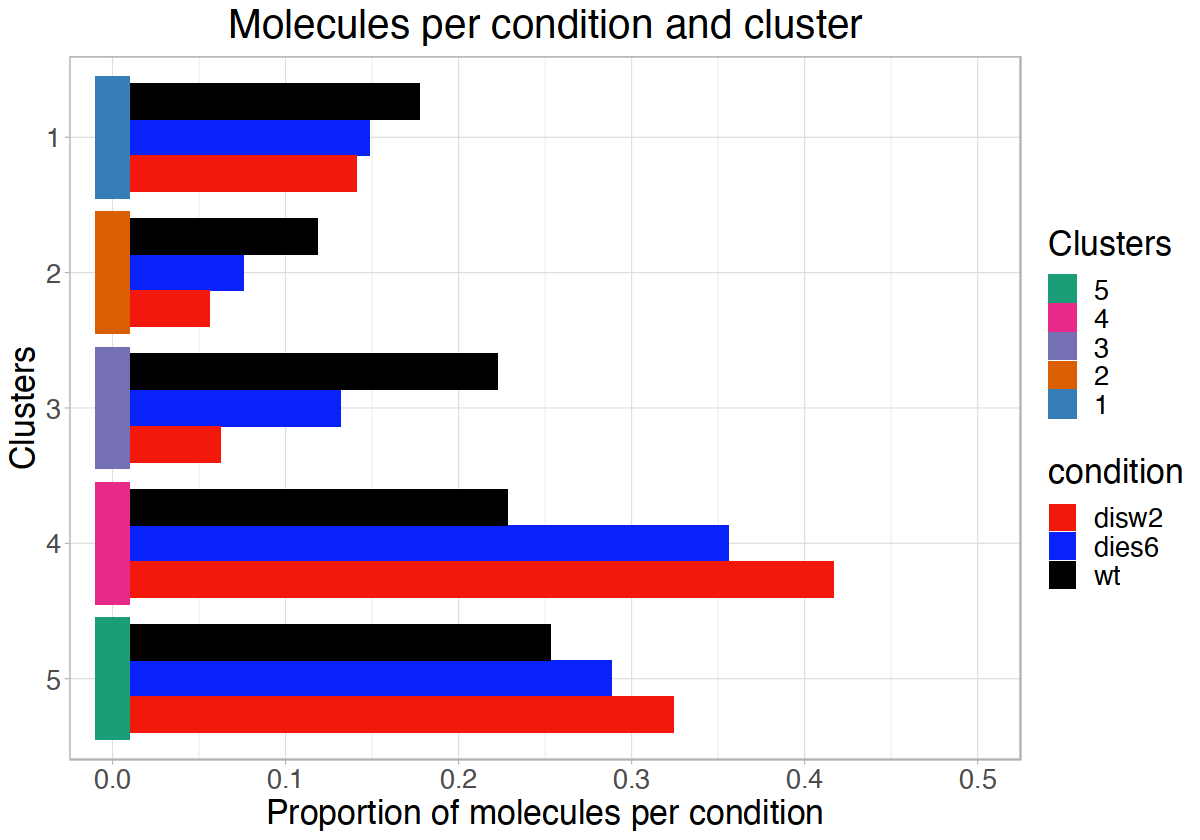

In [48]:
ggplot(data = summarise_proportions, aes(x = cluster_new, y=proportion, fill = condition)) +
  theme_light() + 
  geom_col(position = "dodge", #alpha = 0.6, 
           width = 0.8
          ) +
  scale_fill_manual(values = c("wt" = "black",
                               "dies6" = "#0a22fa", 
                               "disw2" = "#f2180c")) +
  new_scale_fill() +
  geom_tile(data = dplyr::distinct(summarise_proportions, cluster_new), 
            aes(y = 0, x = cluster_new, fill = cluster_new), 
            height = 0.02, width = 0.9, 
            inherit.aes = FALSE) + 
  scale_fill_manual(values = c('1' ='#377eb8',
                               '2'='#D95F02', 
                               '3'='#7570B3', 
                               '4'='#E7298A', 
                               '5'='#1B9E77'),
                    name = "Clusters",
                   ) +
  xlab("Clusters") + 
  ylab("Proportion of molecules per condition") +
  
  ggtitle("Molecules per condition and cluster") +
  theme(text = element_text(size=20),
       plot.title = element_text(hjust = 0.5)) +
  coord_flip(ylim=c(0, 0.5))
#ggsave(paste(load_dir, "/plots/cluster_occupation_ARS316_revision.svg", sep =""), width = 7, height = 10)

## Replot replicates over cluster

In [41]:
aggr_corr_data$corr_groups <- factor(aggr_corr_data$corr_groups, levels = seq(5))

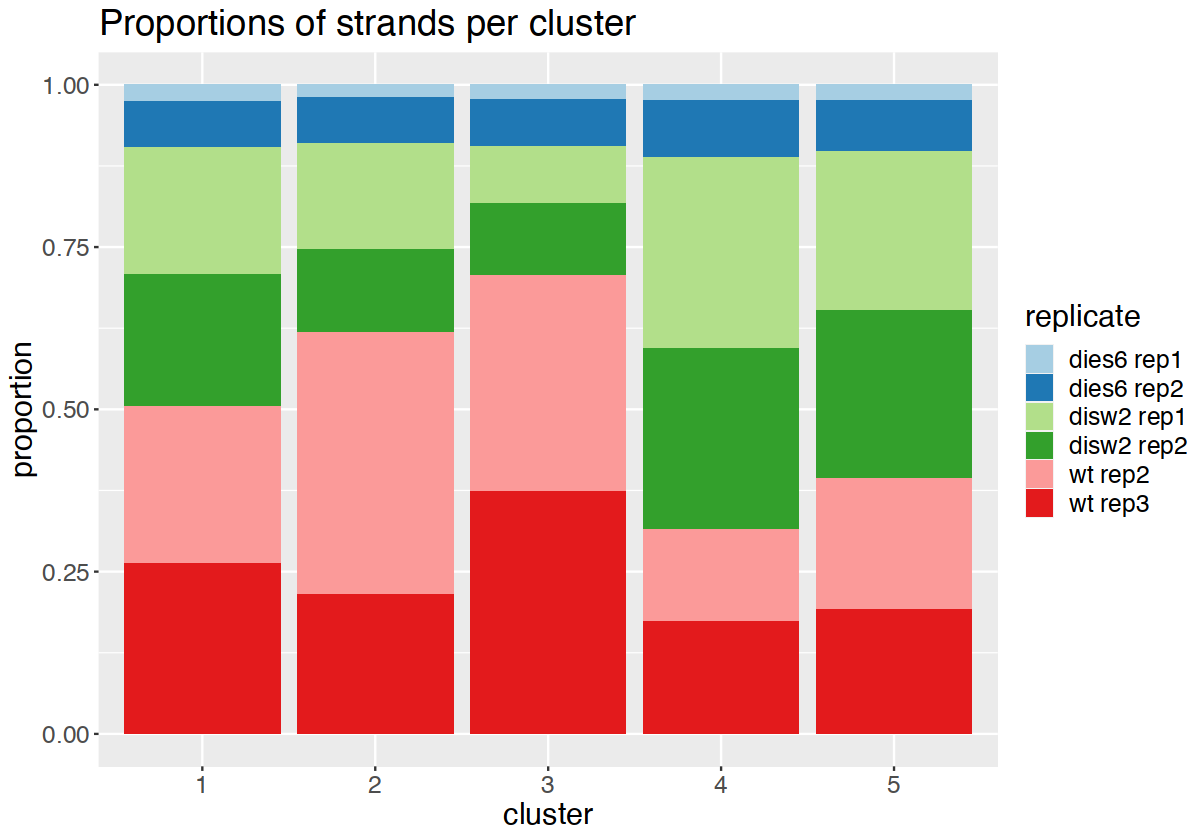

In [42]:
ggplot(data = aggr_corr_data, aes(x = corr_groups, fill = replicate)) +
  geom_bar(position = "fill") + ylab("proportion") + 
  ggtitle("Proportions of strands per cluster")  + 
  xlab("cluster") + 
  scale_fill_brewer(type = "qual", palette = "Paired") + 
  theme(text = element_text(size = 18))
  #ggsave(paste(load_dir, "/plots/cluster_occupation_ARS316_revision_replicates.svg", sep =""), width = 7, height = 5)

In [20]:
num_cluster <- length(unique(corr_groups))

#col_list <- list(cluster = c("1" = '#1B9E77', "2" = '#D95F02', "3" = '#7570B3', "4" = '#E7298A', "5" = '#66A61E'),
#                 condition = c("wt" = "black", "dies6" = "#0a22fa", "disw2" = "#f2180c"))
#Heatmap annotation
ha <- rowAnnotation(
    cluster = aggr_corr_data$corr_groups, 
    condition = aggr_corr_data$condition,
    col = col_list 
)


color_func <- colorRamp2(c(0,1.5,3), brewer.pal(3, "Reds"))#c("#0b5394", "white", "#c53145"))
#aggr_corr_data %>% arrange(groups, condition)%>% select(c(5:14))

#pdf(paste(load_dir, "/plots/heatmap_5cluster_ARS316.pdf", sep=""), width= 10, height=15)
Heatmap(as.matrix(aggr_corr_data[,5:14]), name = "Average feature \n methylation", #title of legend
       row_title = "molecules",
       show_row_names = FALSE,
       row_split = num_cluster,
        cluster_columns = FALSE,
        cluster_rows = as.dendrogram(corr_clust), row_dend_width = unit(3, "cm"),
        #row_order = 
        width = unit(10, "cm"), height = unit(15, "cm"),
        col = color_func, 
        column_title = "Summarized feature methylation of ARS316", column_title_gp = gpar(fontsize = 16, fontface = "bold"),
        left_annotation = ha
       )
#dev.off()

pdf 
  2

In [149]:
aggr_corr_data$total_methylation <- rowSums(aggr_corr_data[,5:14])
plot_sorted_rows <- aggr_corr_data %>% arrange(corr_groups, condition, total_methylation)

aggr_corr_data <- aggr_corr_data[,-ncol (aggr_corr_data)]

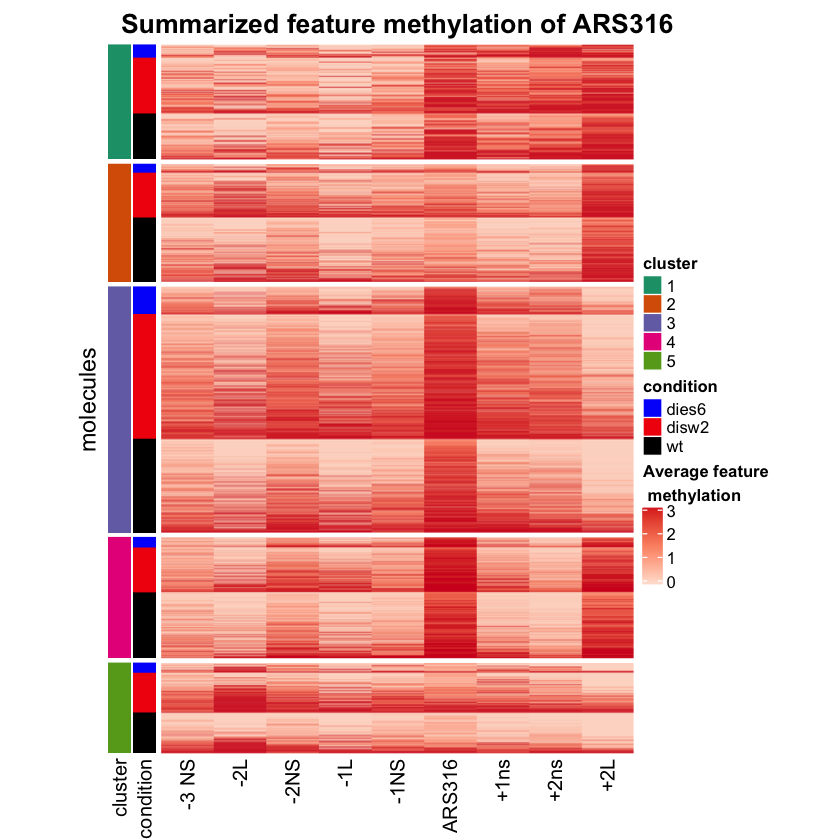

In [150]:
ha2 <- rowAnnotation(
    cluster = plot_sorted_rows$corr_groups, 
    condition = plot_sorted_rows$condition,
    col = col_list 
)

#color_func2 <- colorRamp2(c(0,3.2,8), brewer.pal(3, "Reds"))
color_func2 <- colorRamp2(c(0,1.5,3), brewer.pal(3, "Reds"))

Heatmap(as.matrix(plot_sorted_rows[,5:13]),
       cluster_columns = FALSE, cluster_rows = FALSE,
       left_annotation = ha2,
       show_row_names = FALSE,
       row_split = plot_sorted_rows$corr_groups,
       col = color_func2,
       #col = color_func, 
       name = "Average feature \n methylation", #title of legend
       row_title = "molecules", 
       column_title = "Summarized feature methylation of ARS316", 
        column_title_gp = gpar(fontsize = 16, fontface = "bold"),
       width = unit(10, "cm"), height = unit(15, "cm"), 
       )

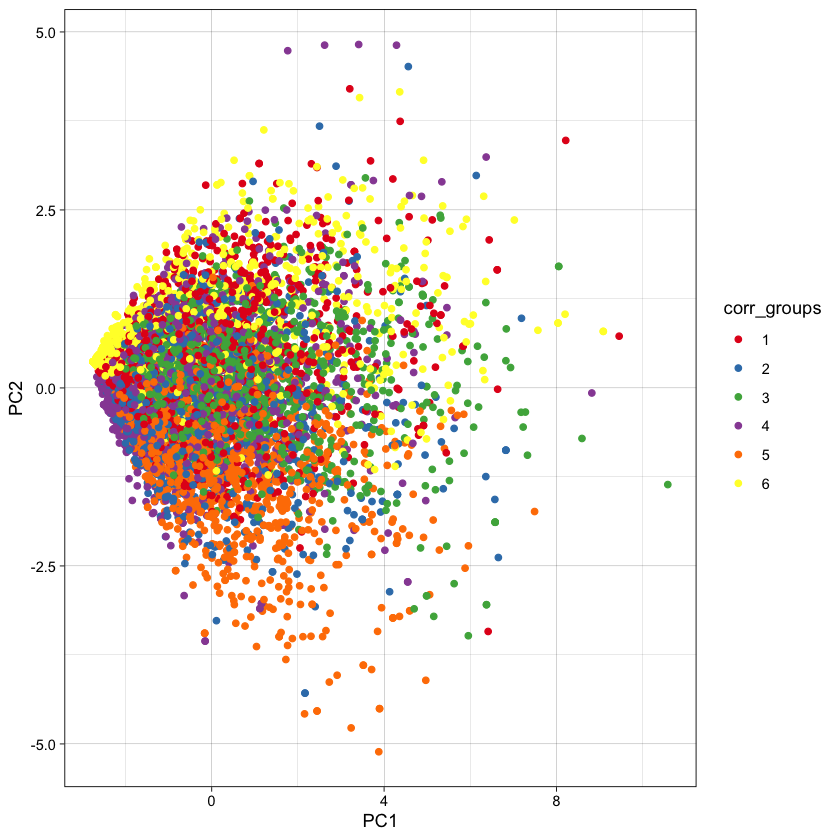

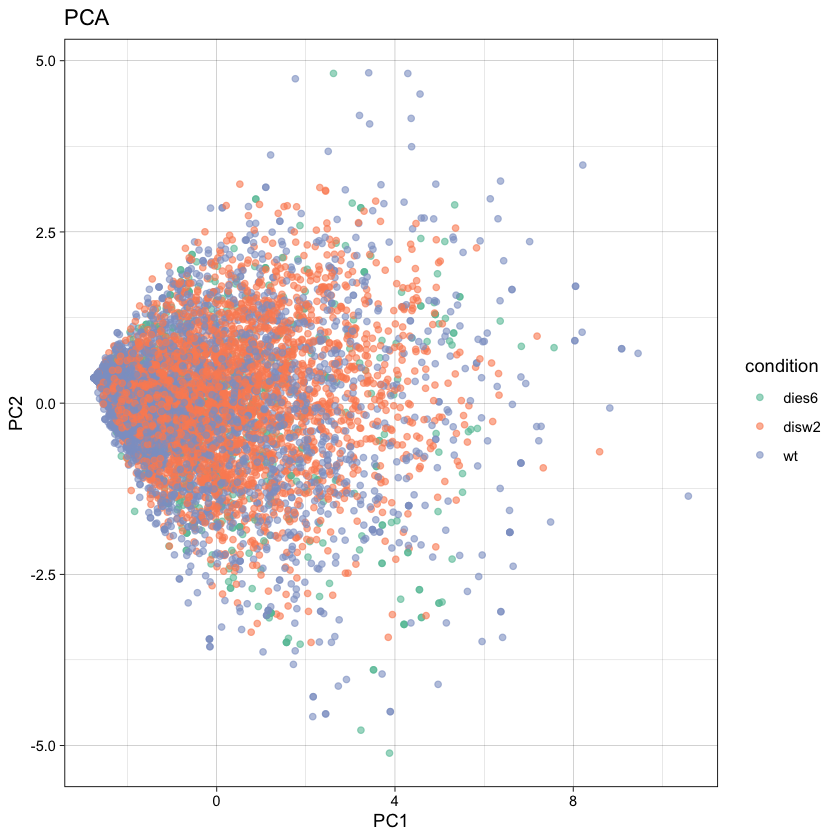

In [135]:
aggr_corr_data$corr_groups <- as.factor(aggr_corr_data$corr_groups)

plot_pc_aggr_data <- cbind(pca_meth$x[,1:2], aggr_corr_data)

ggplot(plot_pc_aggr_data) + 
theme_linedraw() + 
geom_point(aes(x = PC1, y = PC2, color = corr_groups)) +
  scale_color_brewer(type = "qual", palette = "Set1")

ggplot(plot_pc_aggr_data, aes(x = PC1, y = PC2, color= condition)) + 
  theme_linedraw() + 
  geom_point(alpha=0.6) +
  scale_color_brewer(type = "qual", palette = "Set2") +
  labs(title = "PCA")  